In [4]:
import sys
sys.path.append("..")

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from collections import Counter


from scripts.text_cleaning import clean_text, stop_words, extract_domain

from sklearn.feature_extraction.text import CountVectorizer

In [5]:
df = pd.read_csv("../data/raw_analyst_ratings.csv")
news_df = df.copy()
# news_df = df.sample(n=10000, random_state=42)


In [66]:
print("Basic Understanding of the dataset")
print(news_df.info())
print(news_df.head(2))

Basic Understanding of the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB
None
   Unnamed: 0                                    headline  \
0           0     Stocks That Hit 52-Week Highs On Friday   
1           1  Stocks That Hit 52-Week Highs On Wednesday   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   

                        date stock  
0  2020-06-05 

In [67]:
print("Basic Statistics for Textual Lengths in 'headline' Column")

news_df["headline_word_count"] = news_df["headline"].astype(str).str.split().str.len()
news_df["headline_char_count"] = news_df["headline"].astype(str).str.len()

colums_to_describe = ["headline_char_count", "headline_word_count"]

print(news_df[colums_to_describe].describe())


Basic Statistics for Textual Lengths in 'headline' Column
       headline_char_count  headline_word_count
count         1.407328e+06         1.407328e+06
mean          7.312051e+01         1.141671e+01
std           4.073531e+01         6.352997e+00
min           3.000000e+00         1.000000e+00
25%           4.700000e+01         7.000000e+00
50%           6.400000e+01         1.000000e+01
75%           8.700000e+01         1.300000e+01
max           5.120000e+02         7.700000e+01


In [68]:
print("Top 10 Most Active Publishers Based on Article Count:")

top_publishers = (
    news_df.groupby("publisher")
    .agg(article_count=("headline", "count"))
    .sort_values("article_count", ascending=False)
    .head(10)
    .reset_index()
)

print(top_publishers)

Top 10 Most Active Publishers Based on Article Count:
           publisher  article_count
0      Paul Quintaro         228373
1         Lisa Levin         186979
2  Benzinga Newsdesk         150484
3      Charles Gross          96732
4      Monica Gerson          82380
5       Eddie Staley          57254
6         Hal Lindon          49047
7      ETF Professor          28489
8         Juan Lopez          28438
9     Benzinga Staff          28114


Publication Trends over time
Plotting Daily Article Counts Over Time


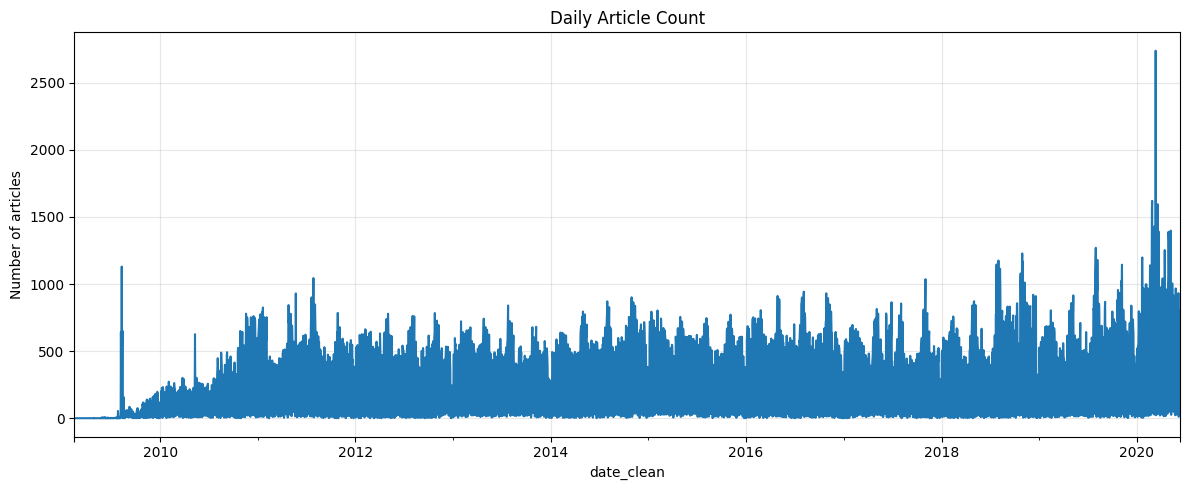

Plotting Monthly Article Counts Over Time


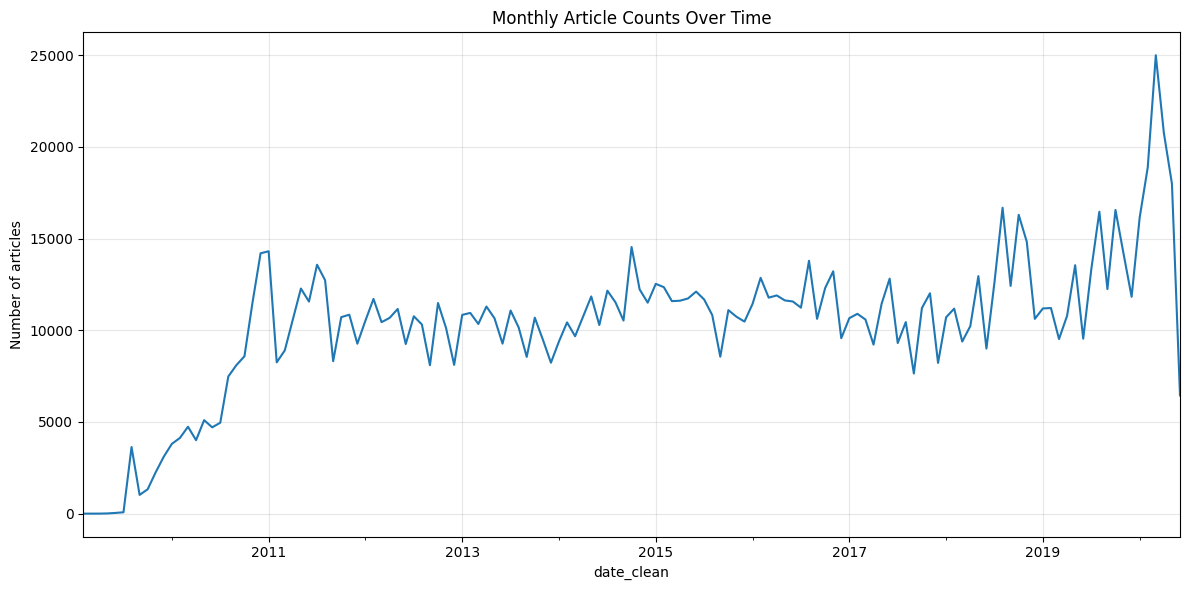

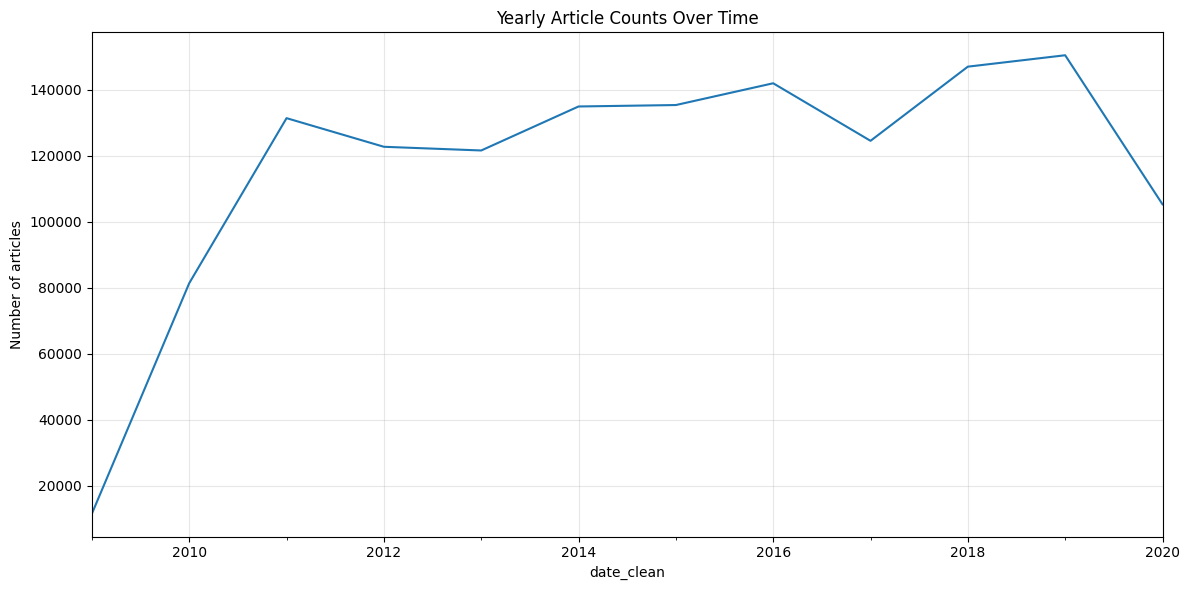

In [69]:
print("Publication Trends over time")

news_df["date_clean"] = pd.to_datetime(news_df["date"], format="mixed", utc=True, errors="coerce")

news_df = news_df.set_index("date_clean").sort_index()

print("Plotting Daily Article Counts Over Time")
daily_counts = news_df.resample("D").size()
daily_counts.plot(figsize=(12, 5), title="Daily Article Count")
plt.ylabel("Number of articles")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


print("Plotting Monthly Article Counts Over Time")
monthly_counts = news_df.resample("ME").size()
monthly_counts.plot(figsize=(12, 6), title="Monthly Article Counts Over Time")
plt.ylabel("Number of articles")
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()


yearly_counts = news_df.resample("YE").size()
yearly_counts.plot(figsize=(12, 6), title="Yearly Article Counts Over Time")
plt.ylabel("Number of articles")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Text Analysis most common words
Most common words in headlines:


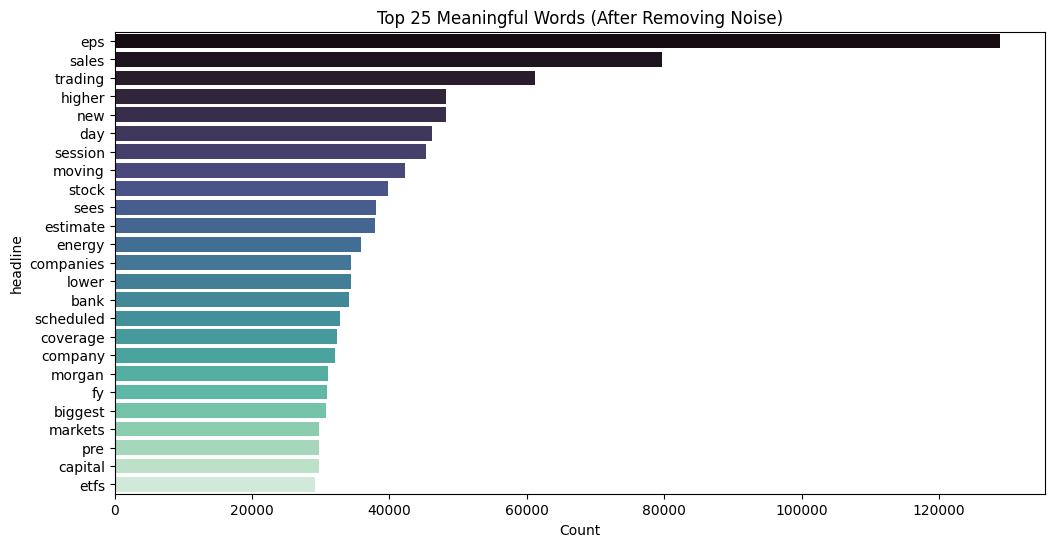

In [70]:
print("Text Analysis most common words")

headlines = news_df["headline"].dropna().apply(clean_text)

print("Most common words in headlines:")


words = headlines.str.split().explode()
words_clean = words[~words.isin(stop_words)]
words_clean = words_clean[words_clean.str.len() > 1]
real_words = words_clean.value_counts().head(25)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=real_words.values, y=real_words.index, palette="mako", hue=real_words.index
)
plt.title("Top 25 Meaningful Words (After Removing Noise)")
plt.xlabel("Count")
plt.show()

In [71]:
print("Text Analysis most common phrases")


vectorizer = CountVectorizer(
    ngram_range=(2, 4),  
    min_df=20, 
    max_df=0.7,
)

X = vectorizer.fit_transform(headlines)
phrase_counts = pd.Series(X.sum(axis=0).A1, index=vectorizer.get_feature_names_out())
phrase_counts = phrase_counts.sort_values(ascending=False)

print("Top 10 Two-Word Phrases:")
print(phrase_counts.head(10))



Text Analysis most common phrases
Top 10 Two-Word Phrases:
companies trading    23340
trading higher       22951
adj eps              21723
pre session          21666
eps sales            20743
trading lower        20099
biggest movers       17795
eps revenue          16852
set new              16801
morgan stanley       15835
dtype: int64


In [72]:
print("Time series analysis")

threshold = daily_counts.mean() + 2 * daily_counts.std()
spike_days = daily_counts[daily_counts > threshold]

news_df["date_clean"] = pd.to_datetime(
    news_df["date"], format="mixed", utc=True, errors="coerce"
)
news_df["date_clean"] = news_df["date_clean"].dt.tz_localize(None)

daily_counts = news_df.groupby(news_df["date_clean"].dt.date).size()

threshold = daily_counts.mean() + 2 * daily_counts.std()
spike_days = daily_counts[daily_counts > threshold]

print(spike_days)

dates_series = pd.Series(news_df["date_clean"].dt.date, index=news_df.index)

spike_headlines = news_df[dates_series.isin(spike_days.index)]["headline"].dropna()

print("Headlines from Spike Days:")
print(spike_headlines.head(20))

Time series analysis
date_clean
2009-08-10    1130
2011-05-23     930
2011-07-28    1044
2016-08-04     943
2016-10-27     931
              ... 
2020-05-07    1398
2020-05-08     927
2020-05-13    1005
2020-05-26     967
2020-06-05     932
Length: 85, dtype: int64
Headlines from Spike Days:
date_clean
2009-08-10 00:00:00+00:00    TSX Venture Exchange Daily Bulletins for Augus...
2009-08-10 00:00:00+00:00    Globalive Wireless Harnesses the Power of Conv...
2009-08-10 00:00:00+00:00    Flow Goes Live With Voice Service in Grenada U...
2009-08-10 00:00:00+00:00      Defrag: Don't Be "Penny Wise and Pound Foolish"
2009-08-10 00:00:00+00:00          Gold Canyon Reviews Springpole Gold Project
2009-08-10 00:00:00+00:00    Castle Resources Begins New Drill Program at t...
2009-08-10 00:00:00+00:00    RothmanResearch.com Stock Review for CPN, ALK,...
2009-08-10 00:00:00+00:00    Wall Street News Alert: Monday's Stock in Focu...
2009-08-10 00:00:00+00:00    Baptist Health System Installs Seve

Analyzing Article Distribution by Day of the Week


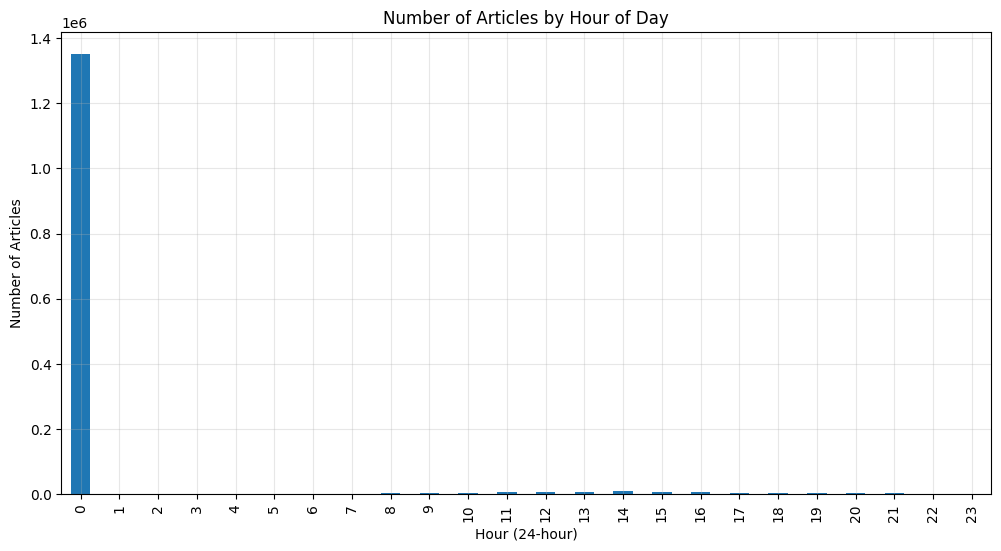

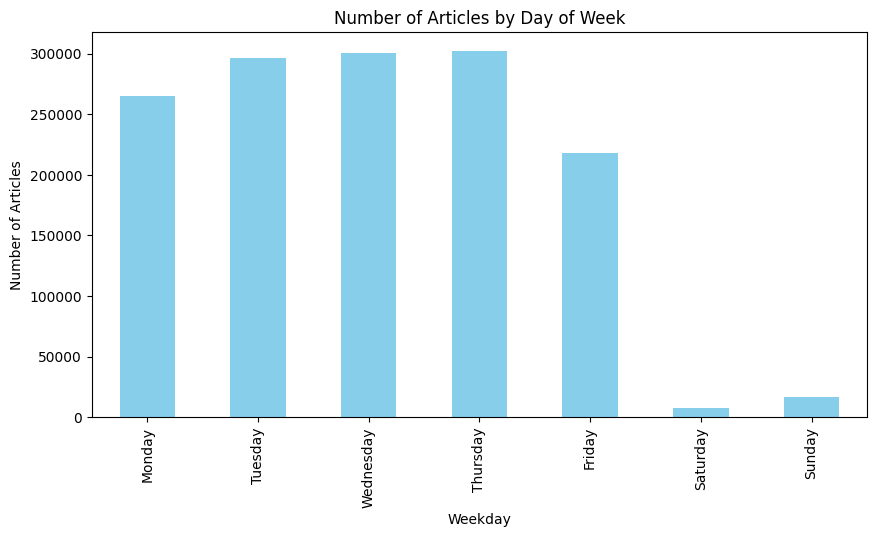

In [73]:
print("Analyzing Article Distribution by Day of the Week")

news_df["weekday"] = news_df["date_clean"].dt.day_name()
news_df["hour"] = news_df["date_clean"].dt.hour

hourly_counts = news_df.groupby("hour").size()
plt.figure(figsize=(12, 6))
hourly_counts.plot(kind="bar")
plt.title("Number of Articles by Hour of Day")
plt.xlabel("Hour (24-hour)")
plt.ylabel("Number of Articles")
plt.grid(alpha=0.3)
plt.show()


weekday_counts = news_df.groupby("weekday").size()
weekday_counts = weekday_counts[
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
] 

plt.figure(figsize=(10, 5))
weekday_counts.plot(kind="bar", color="skyblue")
plt.title("Number of Articles by Day of Week")
plt.xlabel("Weekday")
plt.ylabel("Number of Articles")
plt.show()

In [74]:
print(news_df["date"].head(10))
print(news_df["date_clean"].head(10))

date_clean
2009-02-14 00:00:00+00:00    2009-02-14 00:00:00
2009-04-27 00:00:00+00:00    2009-04-27 00:00:00
2009-04-27 00:00:00+00:00    2009-04-27 00:00:00
2009-04-29 00:00:00+00:00    2009-04-29 00:00:00
2009-05-22 00:00:00+00:00    2009-05-22 00:00:00
2009-05-27 00:00:00+00:00    2009-05-27 00:00:00
2009-05-27 00:00:00+00:00    2009-05-27 00:00:00
2009-05-27 00:00:00+00:00    2009-05-27 00:00:00
2009-05-27 00:00:00+00:00    2009-05-27 00:00:00
2009-05-27 00:00:00+00:00    2009-05-27 00:00:00
Name: date, dtype: object
date_clean
2009-02-14 00:00:00+00:00   2009-02-14
2009-04-27 00:00:00+00:00   2009-04-27
2009-04-27 00:00:00+00:00   2009-04-27
2009-04-29 00:00:00+00:00   2009-04-29
2009-05-22 00:00:00+00:00   2009-05-22
2009-05-27 00:00:00+00:00   2009-05-27
2009-05-27 00:00:00+00:00   2009-05-27
2009-05-27 00:00:00+00:00   2009-05-27
2009-05-27 00:00:00+00:00   2009-05-27
2009-05-27 00:00:00+00:00   2009-05-27
Name: date_clean, dtype: datetime64[ns]


Most contributing publishers over time
Top 10 publishers by number of articles:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


/var/folders/z4/j71xz2fs1270kjsdtgg3ckzh0000gn/T/ipykernel_57096/4017271453.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


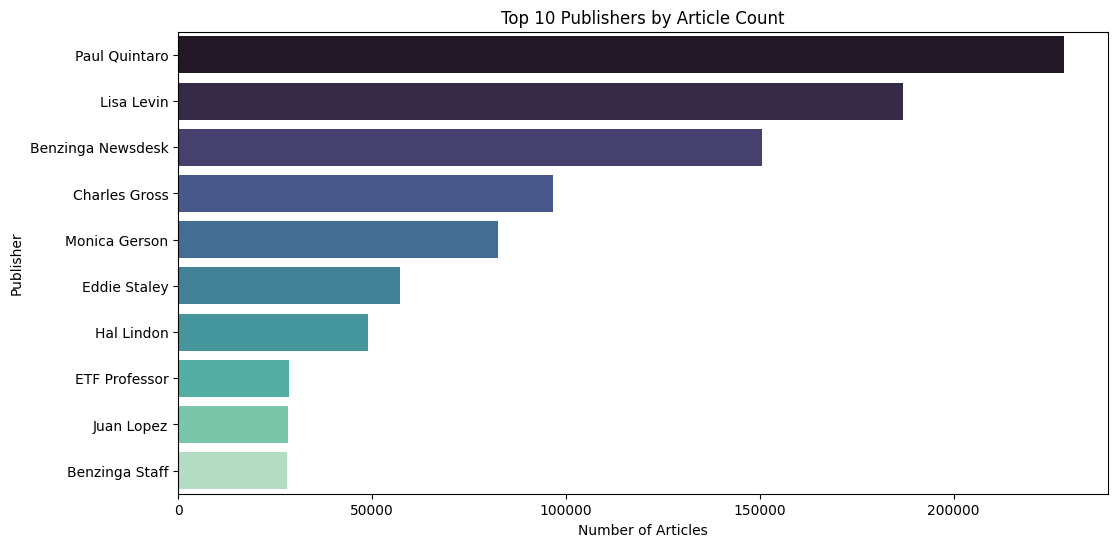

In [ ]:
print("Top 10 publishers by number of articles:")
publisher_counts = news_df["publisher"].value_counts()
top_publishers = publisher_counts.head(10).index.tolist()


print("Top 10 publishers by number of articles:")
print(publisher_counts.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(
    x=publisher_counts.head(10).values,
    y=publisher_counts.head(10).index,
    palette="mako",
)
plt.title("Top 10 Publishers by Article Count")
plt.xlabel("Number of Articles")
plt.ylabel("Publisher")
plt.show()

In [ ]:
print("Analyzing Common Phrases for Top Publishers:")

top_publishers = publisher_counts.head(10).index.tolist()

for publisher in top_publishers:
    print(f"Publisher: {publisher}")

    headlines = news_df[news_df["publisher"] == publisher]["headline"].dropna().apply(clean_text)

    vec2 = CountVectorizer(
        ngram_range=(2, 2), stop_words=list(stop_words), max_features=10
    )
    X2 = vec2.fit_transform(headlines)
    phrases2 = pd.Series(
        X2.sum(axis=0).A1, index=vec2.get_feature_names_out()
    ).sort_values(ascending=False)

    print("Top 10 Two-Word Phrases:")
    print(phrases2.head(10))




Publisher: Paul Quintaro
Top 10 Two-Word Phrases:
eps sales          11905
eps revenue        11194
adj eps            10725
sees fy             7518
fy eps              5773
sees sales          3983
fy sales            3108
sees eps            2951
common stock        2871
corporation eps     2836
dtype: int64
Publisher: Lisa Levin
Top 10 Two-Word Phrases:
biggest movers      17739
pre session         17530
day session         14210
movers yesterday    13942
hit lows             9045
hit highs            8930
morning markets      7029
moving thursday      6878
moving wednesday     6686
biggest day          6666
dtype: int64
Publisher: Benzinga Newsdesk
Top 10 Two-Word Phrases:
companies trading    18976
trading higher       17702
set new              16336
trading lower        16097
new yesterday        12661
estimate sales       12187
beats estimate        8356
eps beats             8321
beat estimate         7697
sales beat            7638
dtype: int64
Publisher: Charles Gross
Top 1

Analyzing Publisher Domains:
publisher_domain
paul quintaro        228373
lisa levin           186979
benzinga newsdesk    150484
charles gross         96732
monica gerson         82380
eddie staley          57254
hal lindon            49047
etf professor         28489
juan lopez            28438
benzinga staff        28114
Name: count, dtype: int64


/var/folders/z4/j71xz2fs1270kjsdtgg3ckzh0000gn/T/ipykernel_80790/4126807774.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


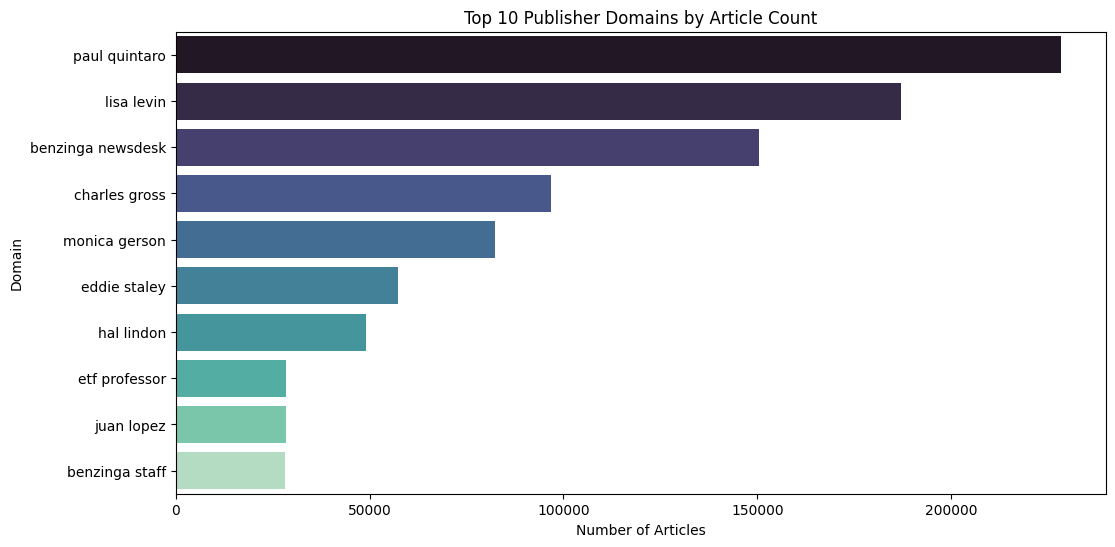

In [10]:
print("Analyzing Publisher Domains:")

news_df["publisher_domain"] = news_df["publisher"].apply(extract_domain)
domain_counts = news_df["publisher_domain"].value_counts()

print(domain_counts.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(
    x=domain_counts.head(10).values, y=domain_counts.head(10).index, palette="mako"
)
plt.title("Top 10 Publisher Domains by Article Count")
plt.xlabel("Number of Articles")
plt.ylabel("Domain")
plt.show()